### Research Methods for Business Analytics 
# Exercise week 1 - Basic statistical concepts

### Learning Objectives
By the end of this notebook, you will be able to:
1. Understand and generate synthetic data for business analysis (optional)
2. Perform exploratory data analysis (EDA) on different types of variables
3. Calculate and interpret descriptive statistics
4. Understand probability distributions and the Central Limit Theorem
5. Apply statistical concepts to business decision-making



### Table of content

Use this table of content to navigate to the respective section.

- [0 Data generation](#0-data-generation)
- [1 Exploratory data analysis](#1-exploratory-data-analysis)
    - [1.1 Types of variables](#11-types-of-variables-in-our-data-set)
    - [1.2 Descriptive statistics](#12-descriptive-statistics)
        - [1.2.1 Frequencies](#121-frequencies)
        - [1.2.2 Measures of central tendency](#122-measures-of-central-tendency)
        - [1.2.3 Correlations](#123-correlations)
        - [1.2.4 Summary statistics table](#124-summary-statistics-table)
- [2 Elements of probability theory](#2-elements-of-probability-theory)
    - [2.1 Sample and population](#21-sample-and-population)
    - [2.2 Comparing sample and population (mean, standard deviation, etc.)](#22-comparing-sample-and-population-mean-standard-deviation)
    - [2.3 Conditional probability](#23-conditional-probability)
- [3 Distributions](#3-distributions)
    - [3.1 Sampling from different distributions](#31-sampling-from-different-distributions)
    - [3.2 Central limit theorem](#32-central-limit-theorem)

# 0. Data Generation

Before we can start with our analysis we need some data. For our exercise, we will simulate data of a streaming platform (similar to Netflix). This allows us to understand the data generation process and use one data set to showcase different statistical methods.

Let's assume that our platform has a population of 200.000 users. 

For the purpose of this exercise, we will simulate the data so that we understand the data generation process.

#### Data Generation Process
We'll create a dataset with the following variables:
- **ID**: Unique identifier for each user
- **age**: User's age (16-99)
- **gender**: User's gender (Male, Female, Diverse)
- **country**: User's country of residence
- **favGenre**: Favorite movie/TV show genre
- **premSub**: Premium subscription status (1 = Yes, 0 = No)
- **satisfaction**: Satisfaction level (1-5 scale)
- **avgHoursWatched**: Average hours watched per day
- **income**: Annual income (with correlations)

#### Data Dictionary

| Variable | Type | Description |
|----------|------|-------------|
| ID | Integer | Unique identifier for each user |
| age | Integer | User's age (16-99) |
| gender | Categorical | User's gender (Male, Female, Diverse) |
| country | Categorical | User's country of residence |
| favGenre | Categorical | Favorite movie/TV show genre |
| premSub | Binary | Premium subscription status (1 = Yes, 0 = No) |
| satisfaction | Ordinal | Satisfaction level (1-5 scale) |
| avgHoursWatched | Continuous | Average hours watched per day |
| income | Continuous | Annual income (with country-based adjustments) |

In [1]:
# simulate data

import pandas as pd
import numpy as np

# Setting seed for reproducibility
np.random.seed(42)


# population size
n = 200000

# 1. Unique id for each observation
user_id = np.arange(1, n+1)

# 2. Age, sampled from a normal distribution
age = np.random.normal(loc=35, scale=12, size=n)
age = np.clip(age, 16, 99).astype(int)  # Ensuring age is between 16 and 99

# 3. Gender with probabilities: 45% Male, 45% Female, 10% Diverse
gender = np.random.choice(['Male', 'Female', 'Diverse'], size=n, p=[0.45, 0.45, 0.10])

# 4. Premium subscription with a probability of 70% for 1 and 30% for 0
premium_subscription = np.random.choice([1, 0], size=n, p=[0.7, 0.3])

# 5. Satisfaction, normally distributed with a mean of 3.5 and standard deviation of 1.5
satisfaction = np.random.normal(loc=3.5, scale=1.5, size=n)
satisfaction = np.clip(satisfaction, 1, 5).round(0)  # Clipping to keep within 1 to 5

# 6. Average hours watched per day, using a power-law distribution
average_hours_watched = np.random.pareto(a=2, size=n) + 1
average_hours_watched = np.clip(average_hours_watched, 0.1, 10).round(1)

# 7. Favorite genre with equal probabilities
favorite_genre = np.random.choice(['Action', 'Romance', 'Comedy', 'Horror', 'Documentary'], size=n)

# 8. Country with equal probabilities
country = np.random.choice(['Portugal', 'France', 'Netherlands', 'Germany', 'Austria', 'Belgium', 'Spain', 'Italy'], size=n)


# 9. Income variable
income = np.random.normal(loc=60000, scale=20000, size=n) # mean of 60.000 and standard deviation of 20.0000

    ## add correlations
        ## negative correlation with hours watched
scaled_hours = (average_hours_watched - average_hours_watched.mean()) # to introduce a negative correlation with average hours watched, we subtract a scaled version of average_hours_watched from the income variable
income = income - scaled_hours * 25000  # Scale the influence for appropriate impact

        ## positive correlation with income
scaled_satisfaction = (satisfaction - satisfaction.mean())
income = income + scaled_satisfaction * 10000  # Adjust the scale factor as needed


    # clip income to assure it stays within range
income = np.clip(income, 10000, 200000)


# Creating the DataFrame
netflix_users = pd.DataFrame({
    'ID': user_id,
    'age': age,
    'gender': gender,
    'country': country,
    'favGenre': favorite_genre,
    'premSub': premium_subscription,
    'satisfaction': satisfaction,
    'avgHoursWatched': average_hours_watched,
    'income':income
})


## income adjustments per country (mean)
country_income_adjustments = {
    'Germany': 15000,
    'Portugal': -5000,
    'France': 10000,
    'Netherlands': 1000,
    'Austria': 8000,
    'Belgium': 17000,
    'Spain': -3000,
    'Italy': -6000
}

# Apply the adjustments to the Income variable
netflix_users['income'] = netflix_users.apply(
    lambda row: row['income'] + country_income_adjustments[row['country']],
    axis=1
)


## income adjustments per country (standard deviation)
# Define the countries and their respective standard deviation adjustment factors
std_dev_adjustments = {
    'Germany': 0.9,  
    'Portugal': 2.0,  
    'Spain': 2.1,  
    'Netherlands': 0.4
}

# Apply the transformation to increase the standard deviation for each specified country
for country, factor in std_dev_adjustments.items():
    # Filter the rows for the specific country
    mask = netflix_users['country'] == country
    
    # Calculate the mean and current standard deviation of Income for this country
    original_mean = netflix_users.loc[mask, 'income'].mean()
    original_std = netflix_users.loc[mask, 'income'].std()
    
    # Apply the transformation to adjust the standard deviation
    netflix_users.loc[mask, 'income'] = original_mean + (netflix_users.loc[mask, 'income'] - original_mean) * factor
    
    # Recalculate the new standard deviation to verify the change
    new_std = netflix_users.loc[mask, 'income'].std()
    

netflix_users["income"] = np.clip(netflix_users["income"], 10000, 2000000)


# adjust premium subscription probabilities

# Define a function to assign premium subscription with different probabilities based on favorite genre
def assign_premium_subscription(row):
    if row['favGenre'] == 'Action':
        # Higher probability for 'Action' genre
        return np.random.choice([1, 0], p=[0.85, 0.15])
    elif row['favGenre'] == 'Romance':
        # Lower probability for 'Romance' genre
        return np.random.choice([1, 0], p=[0.5, 0.5])
    elif row['favGenre'] == 'Documentary':
        # Lower probability for 'Documentary' genre
        return np.random.choice([1, 0], p=[0.12, 0.88])
    else:
        # Default probability for other genres
        return np.random.choice([1, 0], p=[0.6, 0.4])

# Apply the function to the 'Premium_Subscription' column
netflix_users['premSub'] = netflix_users.apply(assign_premium_subscription, axis=1)


# Displaying the first few rows of the dataset
netflix_users.head()


,ID,age,gender,country,favGenre,premSub,satisfaction,avgHoursWatched,income
0,1,40,Female,Netherlands,Action,1,3.0,2.2,74939.489243
1,2,33,Female,Netherlands,Documentary,0,4.0,1.2,78095.330319
2,3,42,Diverse,Spain,Comedy,0,5.0,1.0,62127.363316
3,4,53,Diverse,Spain,Comedy,1,4.0,1.3,103973.576413
4,5,32,Male,France,Action,1,1.0,2.1,34461.429364


# 1. Exploratory data analysis

Before we even think about testing hypotheses and creating statistical models, we start with **an exploratory data analysis (EDA)**. 
In this step we try to understand what type of variables we have in our data set, how they are distributed, and if we can already spot some patterns regarding their joint distribution.

For the EDA, we can use all the tools we discussed in the lecture. However, we need to be careful to select the right 
tools for the right variable.

Typically, we proceed in three steps.

- 1.1 Understand types of variables 
- 1.2 Descriptive statistics of individual variables
- 1.3 Descriptive statistics of correlations (correlation coefficients, scatter plots, correlation plots)

## 1.1 Types of variables in our data set

In [2]:
# INSTRUCTION: write code that indicates the types of variables in the data set (hint: use dtypes)
netflix_users.dtypes

ID                   int64
age                  int64
gender              object
country             object
favGenre            object
premSub              int64
satisfaction       float64
avgHoursWatched    float64
income             float64
dtype: object

In [3]:
netflix_users.columns

Index(['ID', 'age', 'gender', 'country', 'favGenre', 'premSub', 'satisfaction',
       'avgHoursWatched', 'income'],
      dtype='object')

### 1.1.1 Nominal, ordinal, and binary variables
What are the levels?

In [4]:
netflix_users.age

0         40
1         33
2         42
3         53
4         32
          ..
199995    19
199996    41
199997    36
199998    45
199999    22
Name: age, Length: 200000, dtype: int64

In [5]:
netflix_users[['age','ID']]

,age,ID
0,40,1
1,33,2
2,42,3
3,53,4
4,32,5
...,...,...
199995,19,199996
199996,41,199997
199997,36,199998
199998,45,199999


In [7]:
netflix_users['age']

0         40
1         33
2         42
3         53
4         32
          ..
199995    19
199996    41
199997    36
199998    45
199999    22
Name: age, Length: 200000, dtype: int64

In [6]:
# INSTRUCTION: print the unique values of all non-continuous variables
print(netflix_users.age.unique())
print(netflix_users.gender.unique())
print(netflix_users.country.unique())
print(netflix_users.premSub.unique())
print(netflix_users.favGenre.unique())
print(netflix_users.satisfaction.unique())

[40 33 42 53 32 44 29 41 37 16 28 22 38 24 18 52 35 17 36 21 39 27 31 57
 34 20 19 43 26 47 30 46 51 25 45 64 48 61 23 50 67 81 62 60 56 54 49 59
 58 71 55 65 66 63 73 72 68 70 82 69 77 75 74 76 88 78 79 80 85 89]
['Female' 'Diverse' 'Male']
['Netherlands' 'Spain' 'France' 'Germany' 'Portugal' 'Italy' 'Austria'
 'Belgium']
[1 0]
['Action' 'Documentary' 'Comedy' 'Horror' 'Romance']
[3. 4. 5. 1. 2.]


### 1.1.2 Continuous variable

In [7]:
# INSTRUCTION: print the unique values, the min, and the max of the average hours watched variable.
print(netflix_users.avgHoursWatched.unique())
print(netflix_users.avgHoursWatched.min())
print(netflix_users.avgHoursWatched.max())

[ 2.2  1.2  1.   1.3  2.1  1.4  1.1  1.6  1.5 10.   4.2  1.9  1.7  2.3
  4.1  2.   3.9  7.7  3.3  2.9  2.6  3.2  4.   2.7  1.8  2.4  3.8  5.2
  2.5  6.   5.6  2.8  3.1  3.4  5.9  3.   3.5  4.6  4.3  8.5  4.5  8.
  8.3  3.6  5.1  7.2  3.7  5.8  6.7  9.1  6.4  5.5  4.9  5.3  4.8  5.
  6.3  6.2  8.6  5.4  8.2  9.6  6.1  4.4  7.5  5.7  9.3  6.5  8.7  7.8
  4.7  9.8  6.9  8.8  6.8  7.6  9.5  7.   7.4  6.6  7.9  8.1  7.1  8.9
  9.7  7.3  9.4  9.2  8.4  9.   9.9]
1.0
10.0


## 1.2 Descriptive statistics

### 1.2.1 Frequencies

#### Absolute frequency

In [8]:
# INSTRUCTION: compute the absolute frequency for the 'gender' variable.
abs_freq = netflix_users['gender'].value_counts()
abs_freq

gender
Female     90206
Male       89956
Diverse    19838
Name: count, dtype: int64

#### Relative frequency

In [9]:
# INSTRUCTION: compute the relative frequency for the 'gender' variable.
rel_freq = netflix_users['gender'].value_counts(normalize=True) * 100
rel_freq

gender
Female     45.103
Male       44.978
Diverse     9.919
Name: proportion, dtype: float64

#### Frequency plots

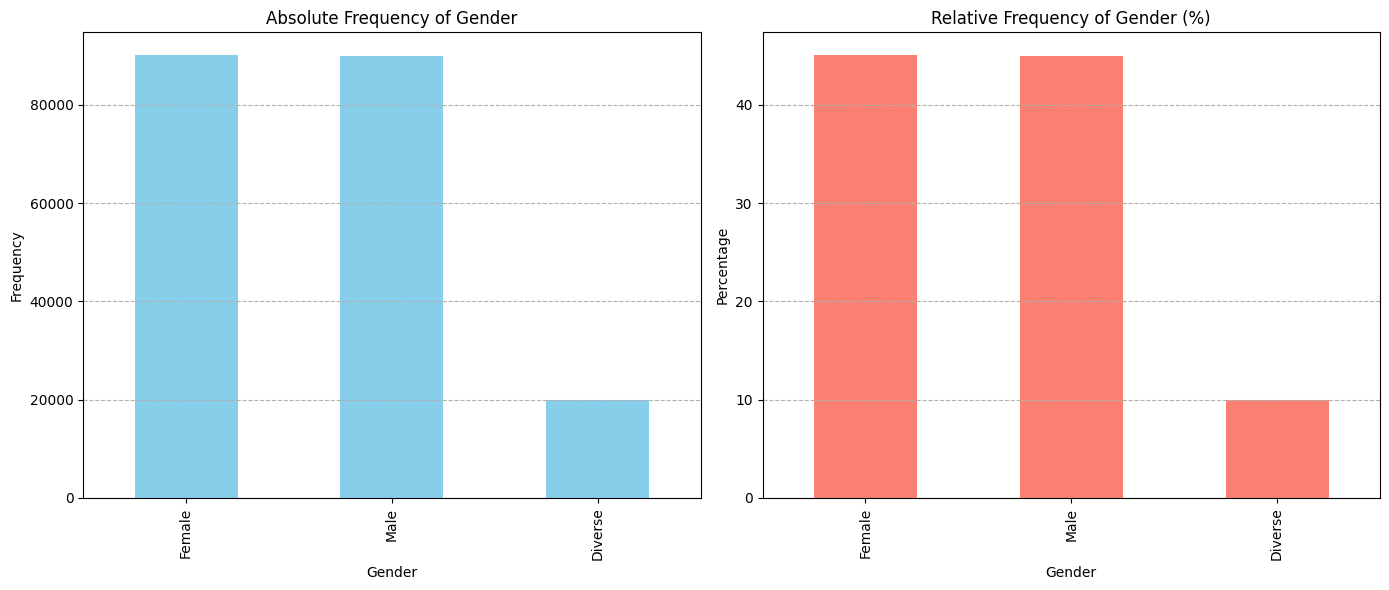

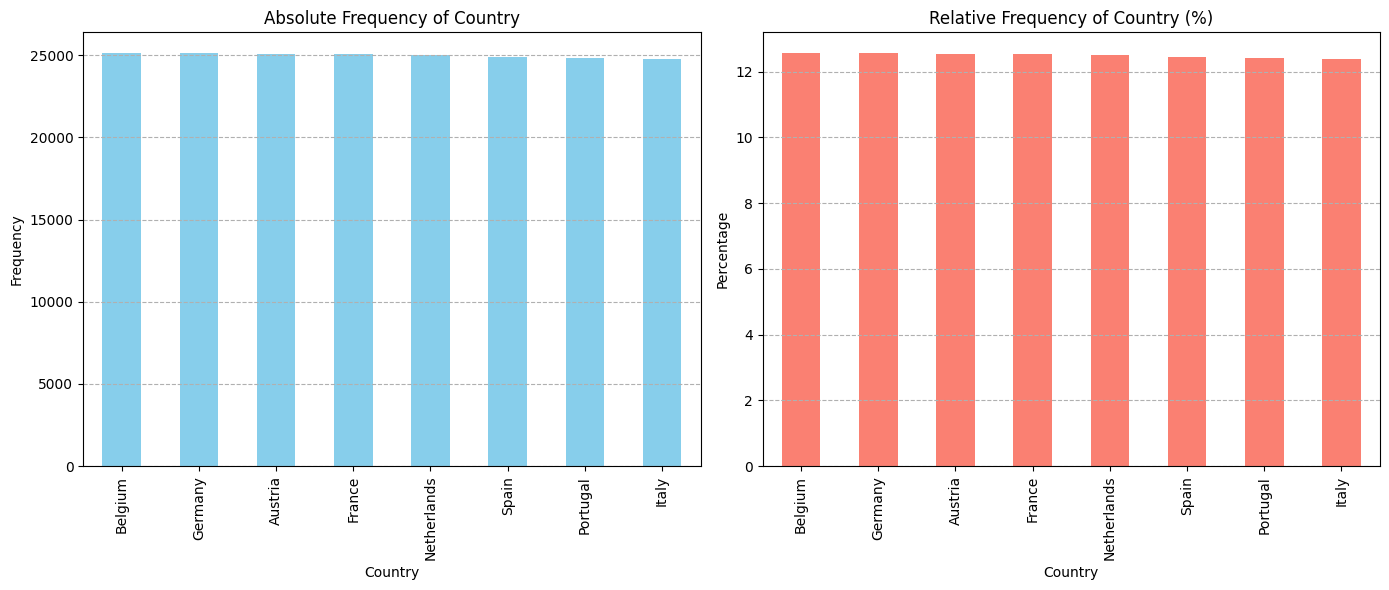

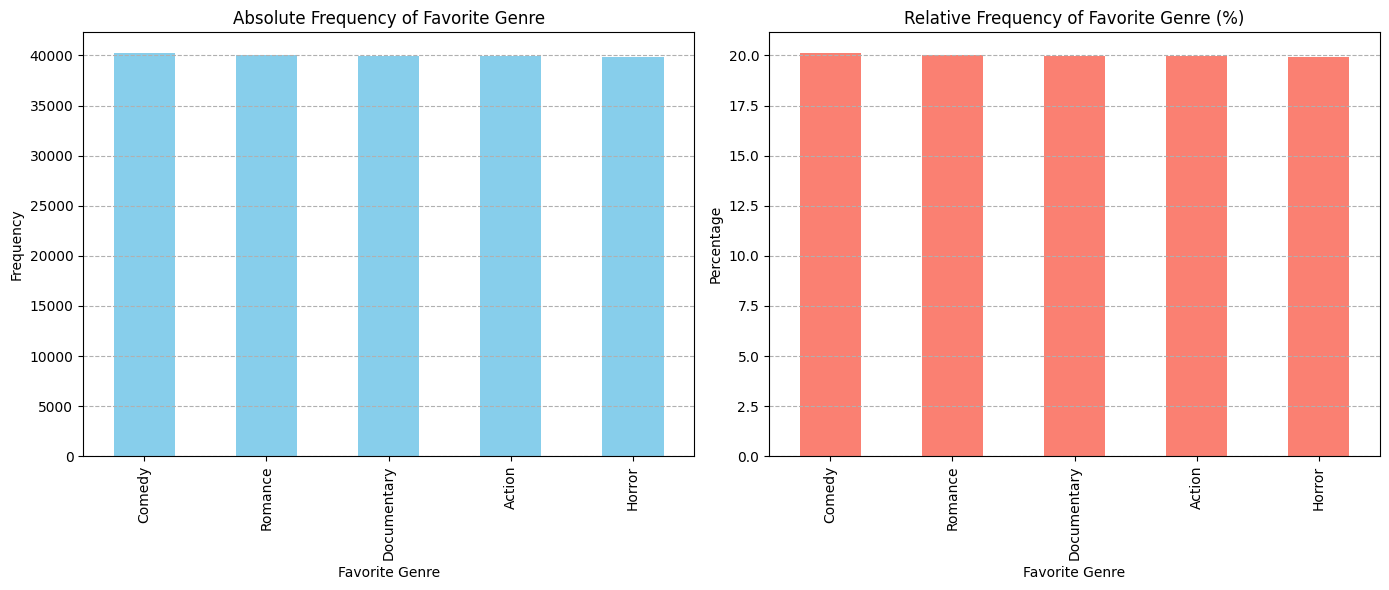

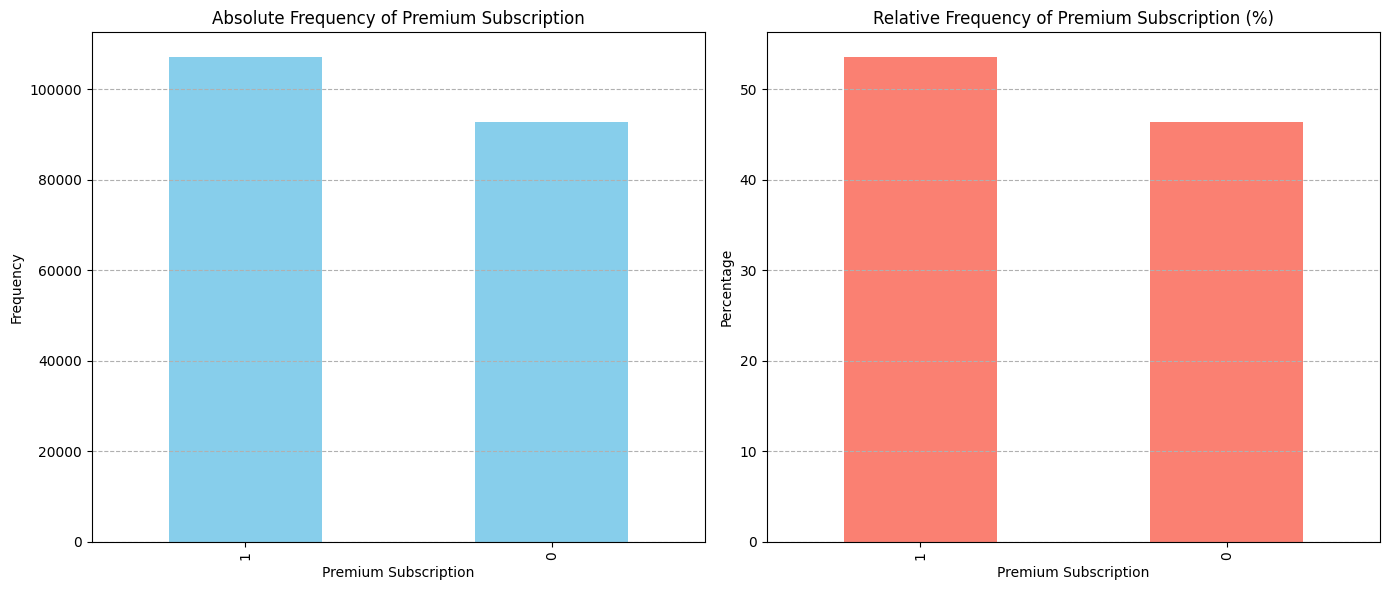

In [10]:
# INSTRUCTION: create an absolute and relative frequency plot for the variables 'gender', 'country', 'favorite genre', and 'premium subscription.

import matplotlib.pyplot as plt

# Function to plot absolute and relative frequency for a given variable
def plot_frequency(variable, title):
    # Calculate absolute frequency
    abs_freq = netflix_users[variable].value_counts()
    
    # Calculate relative frequency
    rel_freq = netflix_users[variable].value_counts(normalize=True) * 100
    
    # Plotting
    plt.figure(figsize=(14, 6))

    # Absolute frequency
    plt.subplot(1, 2, 1)
    abs_freq.plot(kind='bar', color='skyblue')
    plt.title(f'Absolute Frequency of {title}')
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--')

    # Relative frequency
    plt.subplot(1, 2, 2)
    rel_freq.plot(kind='bar', color='salmon')
    plt.title(f'Relative Frequency of {title} (%)')
    plt.xlabel(title)
    plt.ylabel('Percentage')
    plt.grid(axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()

# Plotting for Gender
plot_frequency('gender', 'Gender')

# Plotting for Country
plot_frequency('country', 'Country')

# Plotting for Favorite Genre
plot_frequency('favGenre', 'Favorite Genre')

# Plotting for Premium Subscription
plot_frequency('premSub', 'Premium Subscription')


#### Empirical cumulative distribution function (ECDF)

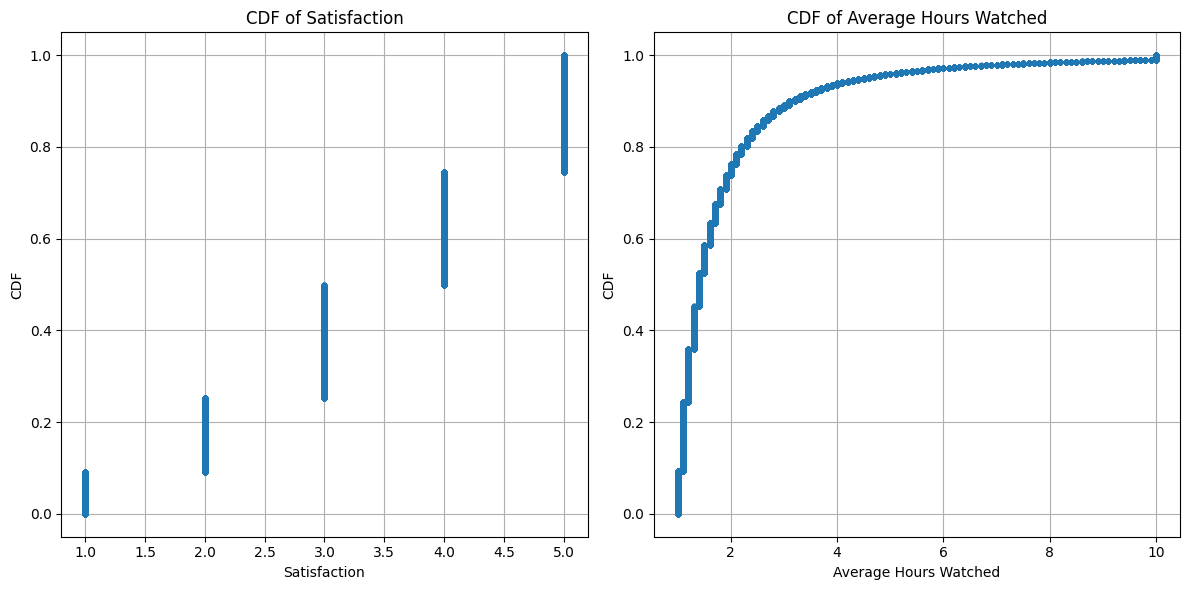

In [11]:
# INSTRUCTION: create a cumulative distribution plot for 'satisfaction' and 'avgHoursWatched'

import matplotlib.pyplot as plt
import numpy as np

# Plotting the CDF for Satisfaction
plt.figure(figsize=(12, 6))

# CDF for Satisfaction
plt.subplot(1, 2, 1)
satisfaction_sorted = np.sort(netflix_users['satisfaction'])
satisfaction_cdf = np.arange(1, len(satisfaction_sorted) + 1) / len(satisfaction_sorted)
plt.plot(satisfaction_sorted, satisfaction_cdf, marker='.', linestyle='none')
plt.title('CDF of Satisfaction')
plt.xlabel('Satisfaction')
plt.ylabel('CDF')
plt.grid(True)

# CDF for Average Hours Watched
plt.subplot(1, 2, 2)
hours_sorted = np.sort(netflix_users['avgHoursWatched'])
hours_cdf = np.arange(1, len(hours_sorted) + 1) / len(hours_sorted)
plt.plot(hours_sorted, hours_cdf, marker='.', linestyle='none')
plt.title('CDF of Average Hours Watched')
plt.xlabel('Average Hours Watched')
plt.ylabel('CDF')
plt.grid(True)

plt.tight_layout()
plt.show()


#### Bar vs. pie chart

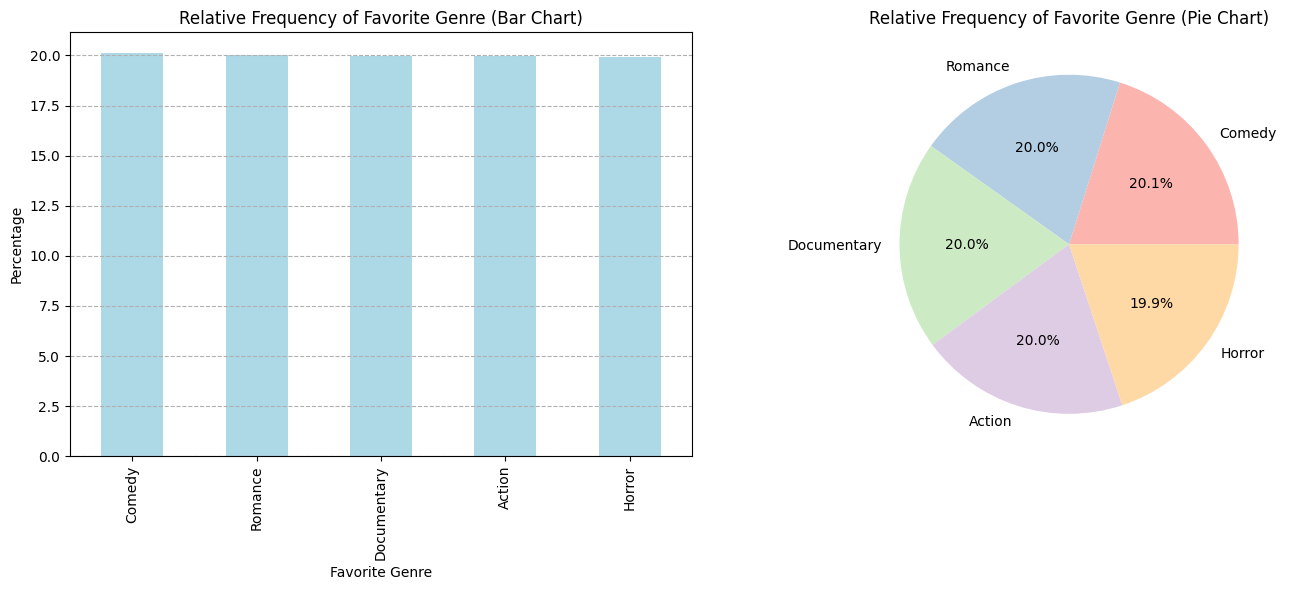

In [12]:
# INSTRUCTION: create a bar chart and a pie chart for the relative frequencies of the variable 'favGenre'.

# Calculate relative frequency of Favorite_Genre
rel_freq_genre = netflix_users['favGenre'].value_counts(normalize=True) * 100

# Plotting the relative frequency as a bar chart
plt.figure(figsize=(14, 6))

# Bar chart
plt.subplot(1, 2, 1)
rel_freq_genre.plot(kind='bar', color='lightblue')
plt.title('Relative Frequency of Favorite Genre (Bar Chart)')
plt.xlabel('Favorite Genre')
plt.ylabel('Percentage')
plt.grid(axis='y', linestyle='--')

# Pie chart
plt.subplot(1, 2, 2)
rel_freq_genre.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Pastel1.colors)
plt.title('Relative Frequency of Favorite Genre (Pie Chart)')
plt.ylabel('')  # Hide the y-label

plt.tight_layout()
plt.show()

#### Histogram vs. kernel density plot

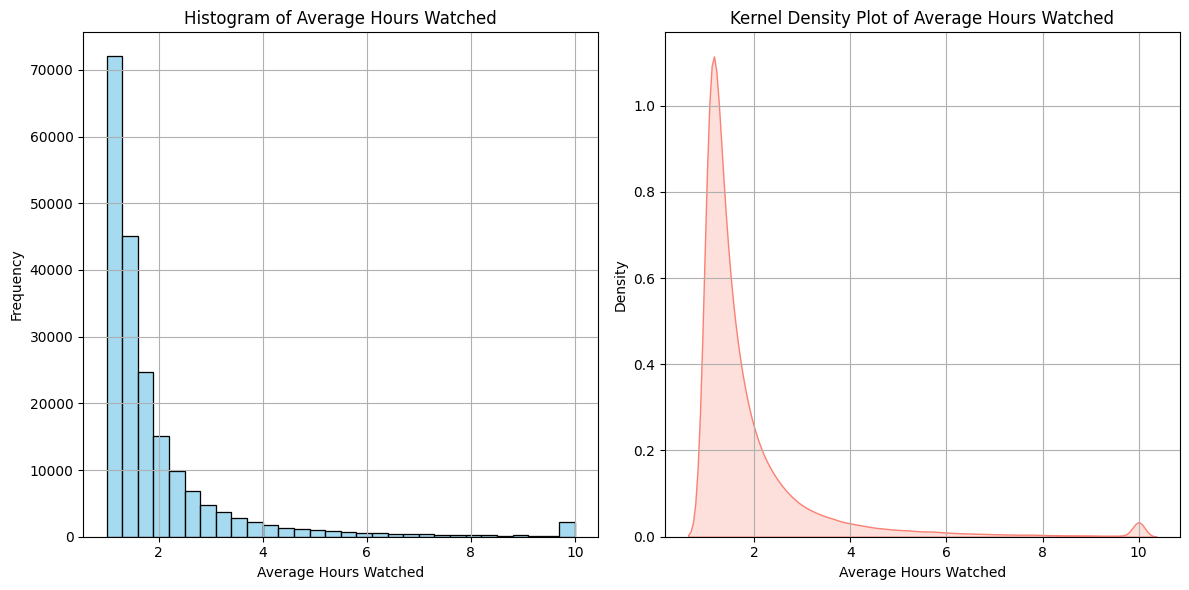

In [13]:
# INSTRUCTION: create a histogram and a kernel density plot for the variable 'avgHoursWatched'

import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for the plots
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(netflix_users['avgHoursWatched'], bins=30, kde=False, color='skyblue')
plt.title('Histogram of Average Hours Watched')
plt.xlabel('Average Hours Watched')
plt.ylabel('Frequency')
plt.grid(True)

# Kernel Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(netflix_users['avgHoursWatched'], fill=True, color='salmon')
plt.title('Kernel Density Plot of Average Hours Watched')
plt.xlabel('Average Hours Watched')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()
plt.show()


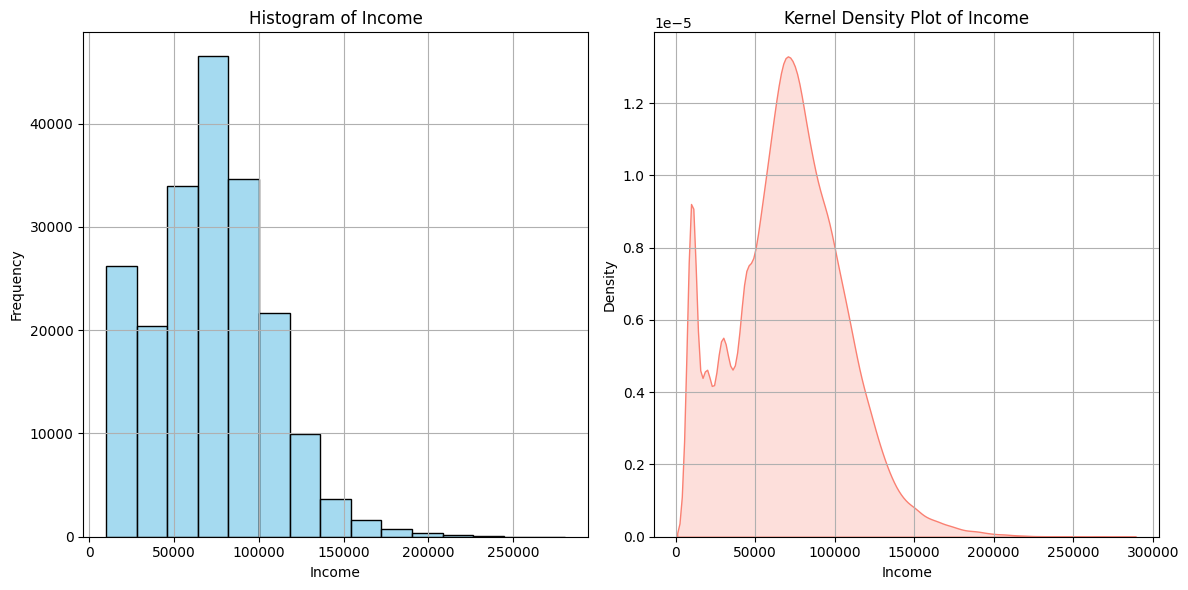

In [12]:
# INSTRUCTION: create a histogram and a kernel density plot for the variable 'income'

# Set the figure size for the plots
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(netflix_users['income'], bins=15, kde=False, color='skyblue')
plt.title('Histogram of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.grid(True)

# Kernel Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(netflix_users['income'], fill=True, color='salmon')
plt.title('Kernel Density Plot of Income')
plt.xlabel('Income')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()
plt.show()


### 1.2.2 Measures of central tendency

#### Minimum, maximum, range

In [14]:
#INSTRUCTION: compute min, max, and range for satisfaction, avgHoursWatched, and Income
min_satisfaction = netflix_users['satisfaction'].min()
max_satisfaction = netflix_users['satisfaction'].max()
range_satisfaction = max_satisfaction - min_satisfaction

min_hours_watched = netflix_users['avgHoursWatched'].min()
max_hours_watched = netflix_users['avgHoursWatched'].max()
range_hours_watched = max_hours_watched - min_hours_watched

min_income = netflix_users['income'].min()
max_income = netflix_users['income'].max()
range_income = max_income - min_income

# Print the results
print("Satisfaction:")
print(f"  Min: {min_satisfaction}")
print(f"  Max: {max_satisfaction}")
print(f"  Range: {range_satisfaction}\n")

print("Average Hours Watched:")
print(f"  Min: {min_hours_watched}")
print(f"  Max: {max_hours_watched}")
print(f"  Range: {range_hours_watched}\n")

print("Income:")
print(f"  Min: {min_income}")
print(f"  Max: {max_income}")
print(f"  Range: {range_income}")

Satisfaction:
  Min: 1.0
  Max: 5.0
  Range: 4.0

Average Hours Watched:
  Min: 1.0
  Max: 10.0
  Range: 9.0

Income:
  Min: 10000.0
  Max: 280480.4849554007
  Range: 270480.4849554007


#### Mean, median, mode, quantiles

In [16]:
# INSTRUCTION: compute mean, media, quantiles, and mode
mean_satisfaction = netflix_users['satisfaction'].mean()
median_satisfaction = netflix_users['satisfaction'].median()
q25_satisfcation = netflix_users['satisfaction'].quantile(0.25)
q75_satisfaction = netflix_users['satisfaction'].quantile(0.75)
mode_satisfaction = netflix_users['satisfaction'].mode()

mean_hours_watched = netflix_users['avgHoursWatched'].mean()
median_hours_watched = netflix_users['avgHoursWatched'].median()
q25_hours_watched = netflix_users['avgHoursWatched'].quantile(0.25)
q75_hours_watched = netflix_users['avgHoursWatched'].quantile(0.75)
mode_hours_watched = netflix_users['avgHoursWatched'].mode()

mean_income = netflix_users['income'].mean()
median_income = netflix_users['income'].median()
q25_income = netflix_users['income'].quantile(0.25)
q75_income = netflix_users['income'].quantile(0.75)
mode_income = netflix_users['income'].mode()

# Print the results
print("Satisfaction:")
print(f"  Mean: {mean_satisfaction}")
print(f"  Median: {median_satisfaction}")
print(f"  25th percentile: {q25_satisfcation}")
print(f"  75th percentile: {q75_satisfaction}")
print(f"  Mode: {mode_satisfaction}\n")

print("Average Hours Watched:")
print(f"  Mean: {mean_hours_watched}")
print(f"  Median: {median_hours_watched}")
print(f"  25th percentile: {q25_hours_watched}")
print(f"  75th percentile: {q75_hours_watched}")
print(f"  Mode: {mode_hours_watched}\n")

print("Income:")
print(f"  Mean: {mean_income}")
print(f"  Median: {median_income}")
print(f"  25th percentile: {q25_income}")
print(f"  75th percentile: {q75_income}")
print(f"  Mode: {mode_income}")

Satisfaction:
  Mean: 3.41281
  Median: 4.0
  25th percentile: 2.0
  75th percentile: 5.0
  Mode: 0    5.0
Name: satisfaction, dtype: float64

Average Hours Watched:
  Mean: 1.9007039999999997
  Median: 1.4
  25th percentile: 1.2
  75th percentile: 2.0
  Mode: 0    1.1
Name: avgHoursWatched, dtype: float64

Income:
  Mean: 71218.28267609914
  Median: 71430.56671786447
  25th percentile: 48468.35541731646
  75th percentile: 93321.47819491496
  Mode: 0    10000.0
Name: income, dtype: float64


#### Variance, standard deviation

In [17]:
# INSTRUCTION: compute the variance and standard deviation for the variables 'satisfaction', 'avgHoursWatched', 'income'.

# Compute variance and standard deviation for Satisfaction
satisfaction_variance = netflix_users['satisfaction'].var()
satisfaction_std_dev = netflix_users['satisfaction'].std()

# Compute variance and standard deviation for Average Hours Watched
hours_watched_variance = netflix_users['avgHoursWatched'].var()
hours_watched_std_dev = netflix_users['avgHoursWatched'].std()

# Compute variance and standard deviation for Income
income_variance = netflix_users['income'].var()
income_std_dev = netflix_users['income'].std()

# Print the results
print("Satisfaction:")
print(f"  Variance: {satisfaction_variance:.2f}")
print(f"  Standard Deviation: {satisfaction_std_dev:.2f}\n")

print("Average Hours Watched:")
print(f"  Variance: {hours_watched_variance:.2f}")
print(f"  Standard Deviation: {hours_watched_std_dev:.2f}\n")

print("Income:")
print(f"  Variance: {income_variance:.2f}")
print(f"  Standard Deviation: {income_std_dev:.2f}")

Satisfaction:
  Variance: 1.62
  Standard Deviation: 1.27

Average Hours Watched:
  Variance: 2.02
  Standard Deviation: 1.42

Income:
  Variance: 1203576975.83
  Standard Deviation: 34692.61


#### Skewness, kurtosis, and transformations

**Skewness**

Skewness = 0: Then normally distributed. <br>
Skewness > 0: Then more weight in the left tail of the distribution. <br>
Skewness < 0: Then more weight in the right tail of the distribution. <br>


**Kurtosis**

kurtosis for normal distribution is equal to 3. <br>
For a distribution having kurtosis < 3: It is called playkurtic (fewer observations on the tail/s). <br>
For a distribution having kurtosis > 3, It is called leptokurtic and it signifies that it tries to produce more outliers rather than the normal distribution. <br>

In [18]:
#INSTRUCTION: compute the skewness and kurtosis of the variable 'avgHoursWatched'. (Hint: use skew() and kurtosis() form scipy.stats)

from scipy.stats import skew 
from scipy.stats import kurtosis 

# Calculate the skewness 
print('skewness:', str(skew(netflix_users.avgHoursWatched, axis=0, bias=True)))
# Calculate the kurtosis 
print('kurtosis:', str(kurtosis(netflix_users.avgHoursWatched, axis=0, bias=True)))

skewness: 3.4541243426763932
kurtosis: 14.049222347145736


A value of three shows that this variable is highly positively skewed. <br>

We can confirm this by looking at out kernel density plot

But what can we do about this?

We could try to transform the variable. 

One of the the most common transformations is the log or ln transformation. 



**Log transformation**

In [19]:
#INSTRUCTION: log10 and ln transfor the variable 'avgHoursWatched
netflix_users['avgHoursWatched_log2'] = np.log2(netflix_users['avgHoursWatched'])
netflix_users['avgHoursWatched_log10'] = np.log10(netflix_users['avgHoursWatched'])

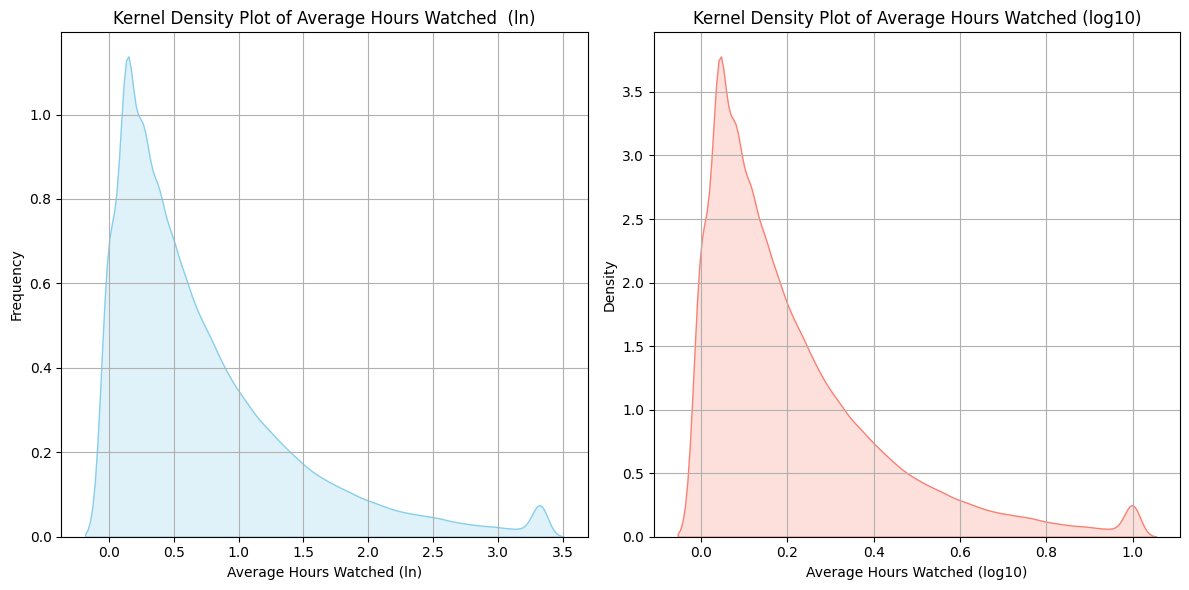

skewness ln transform: 1.5664461038241047
skewness log10 transform: 1.5664461038241044
kurtosis ln transform: 2.4640111149474375
kurtosis log10 transform: 2.4640111149474366


In [22]:
#INSTRUCTION: plot the kernel density plot of the log and ln transformed variable

# Set the figure size for the plots
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.kdeplot(netflix_users['avgHoursWatched_log2'], fill=True, color='skyblue')
plt.title('Kernel Density Plot of Average Hours Watched  (ln)')
plt.xlabel('Average Hours Watched (ln)')
plt.ylabel('Frequency')
plt.grid(True)

# Kernel Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(netflix_users['avgHoursWatched_log10'], fill=True, color='salmon')
plt.title('Kernel Density Plot of Average Hours Watched (log10)')
plt.xlabel('Average Hours Watched (log10)')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()
plt.show()


# Calculate the skewness 
print('skewness ln transform:', str(skew(netflix_users.avgHoursWatched_log2, axis=0, bias=True)))
print('skewness log10 transform:', str(skew(netflix_users.avgHoursWatched_log10, axis=0, bias=True)))
# Calculate the kurtosis 
print('kurtosis ln transform:', str(kurtosis(netflix_users.avgHoursWatched_log2, axis=0, bias=True)))
print('kurtosis log10 transform:', str(kurtosis(netflix_users.avgHoursWatched_log10, axis=0, bias=True)))

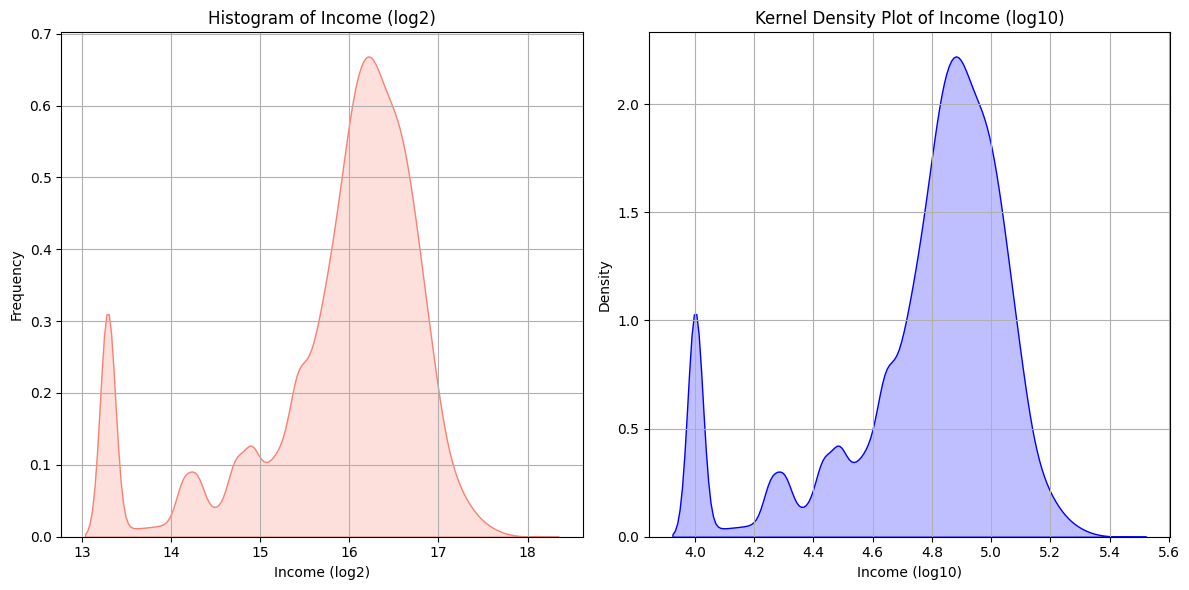

In [ ]:
# Set the figure size for the plots
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.kdeplot(np.log2(netflix_users['income']), fill=True, color='salmon')
plt.title('Histogram of Income (log2)')
plt.xlabel('Income (log2)')
plt.ylabel('Frequency')
plt.grid(True)

# Kernel Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(np.log10(netflix_users['income']), fill=True, color='blue')
plt.title('Kernel Density Plot of Income (log10)')
plt.xlabel('Income (log10)')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Box plots

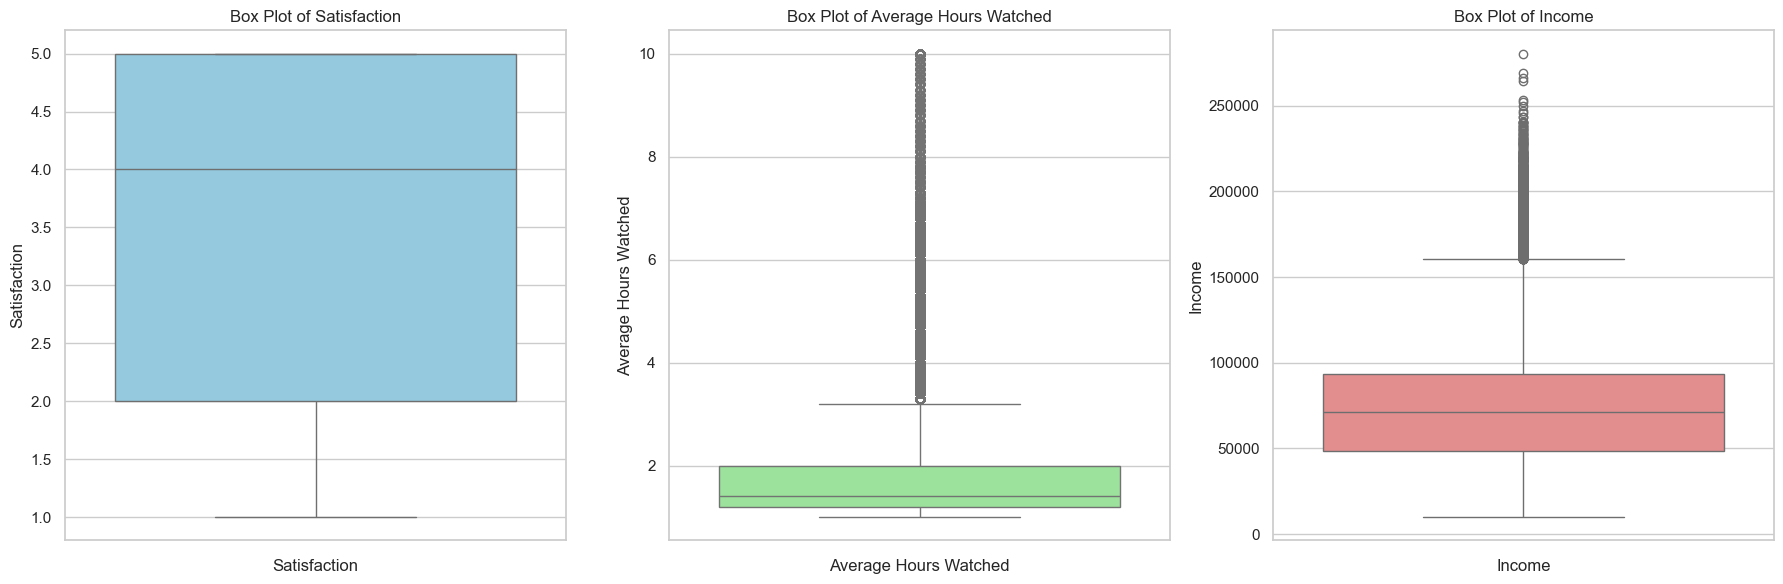

In [23]:
#INSTRUCTION: create a box plot of the variables 'satisfaction', 'avgHoursWatched', 'income'.

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure and axis objects
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the box plot for Satisfaction
sns.boxplot(y=netflix_users['satisfaction'], ax=axes[0], color='skyblue')
axes[0].set_title('Box Plot of Satisfaction')
axes[0].set_xlabel('Satisfaction')
axes[0].set_ylabel('Satisfaction')

# Plot the box plot for Average Hours Watched
sns.boxplot(y=netflix_users['avgHoursWatched'], ax=axes[1], color='lightgreen')
axes[1].set_title('Box Plot of Average Hours Watched')
axes[1].set_xlabel('Average Hours Watched')
axes[1].set_ylabel('Average Hours Watched')

# Plot the box plot for Income
sns.boxplot(y=netflix_users['income'], ax=axes[2], color='lightcoral')
axes[2].set_title('Box Plot of Income')
axes[2].set_xlabel('Income')
axes[2].set_ylabel('Income')

# Display the plots
plt.tight_layout()
plt.show()


### 1.2.3 Correlations

#### Scatter plots

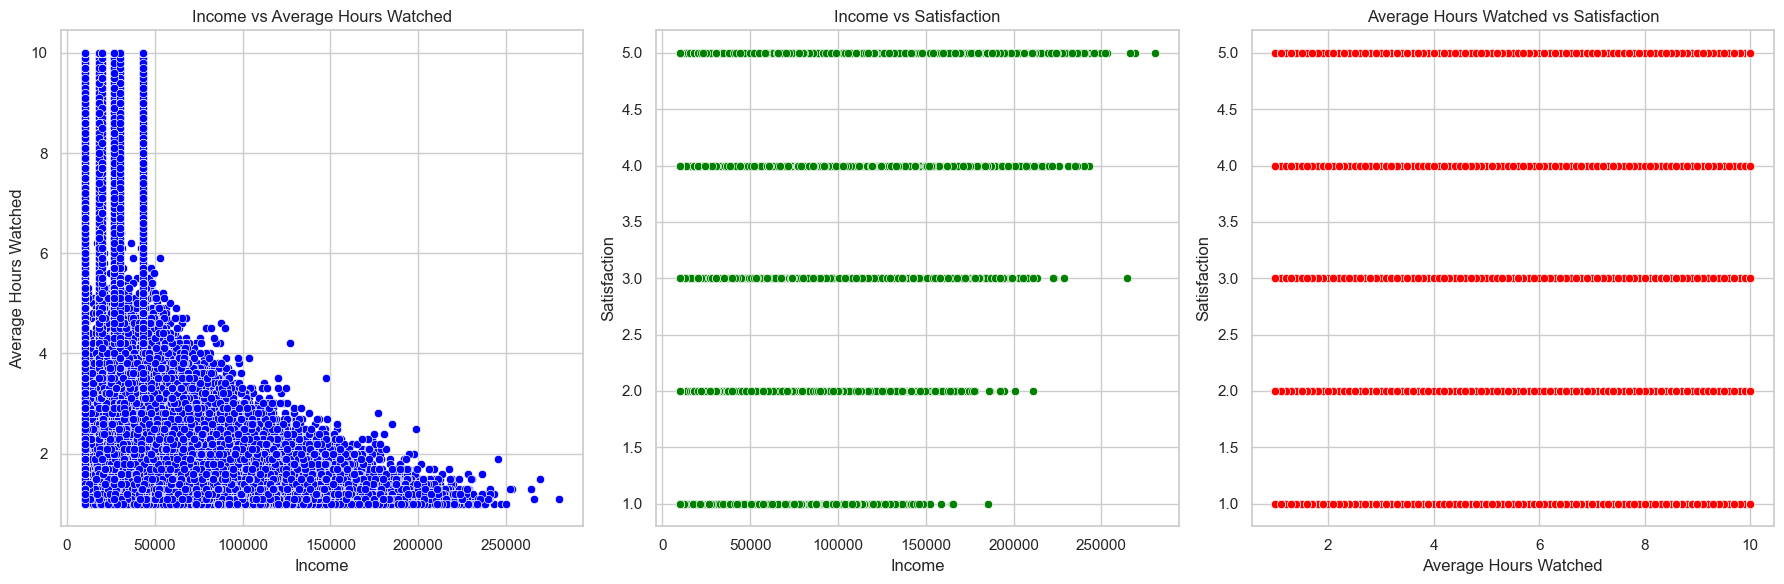

In [24]:
#INSTRUCTION: create three scatter plots: (1)'income' vs. 'avgHoursWatched', (2) 'income' vs. 'satisfaction', (3) 'avgHoursWatched' vs. 'satisfaction'.

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure and axis objects
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot of Income vs Average Hours Watched
sns.scatterplot(x=netflix_users['income'], y=netflix_users['avgHoursWatched'], ax=axes[0], color='blue')
axes[0].set_title('Income vs Average Hours Watched')
axes[0].set_xlabel('Income')
axes[0].set_ylabel('Average Hours Watched')

# Scatter plot of Income vs Satisfaction
sns.scatterplot(x=netflix_users['income'], y=netflix_users['satisfaction'], ax=axes[1], color='green')
axes[1].set_title('Income vs Satisfaction')
axes[1].set_xlabel('Income')
axes[1].set_ylabel('Satisfaction')

# Scatter plot of Average Hours Watched vs Satisfaction
sns.scatterplot(x=netflix_users['avgHoursWatched'], y=netflix_users['satisfaction'], ax=axes[2], color='red')
axes[2].set_title('Average Hours Watched vs Satisfaction')
axes[2].set_xlabel('Average Hours Watched')
axes[2].set_ylabel('Satisfaction')

# Display the plots
plt.tight_layout()
plt.show()


#### Covariance

In [25]:
#INSTRUCTION: compute the covariance matrix of 'income', 'avgHoursWatched', 'satisfaction'.
netflix_users[['income', 'avgHoursWatched', 'satisfaction']].cov()

,income,avgHoursWatched,satisfaction
income,1.203577e+09,-24113.425880,16255.446088
avgHoursWatched,-2.411343e+04,2.020281,0.006008
satisfaction,1.625545e+04,0.006008,1.616736


#### Correlation coefficients (pearson, spearman)

In [26]:
#INSTRUCTION: compute and compare the pearson, and spearman correlation matrix for the variables 'income', 'avgHoursWatched', 'satisfaction'. Which matrix would you report?

import pandas as pd

# Compute the Pearson correlation matrix
pearson_corr = netflix_users[['income', 'satisfaction', 'avgHoursWatched']].corr(method='pearson')

# Compute the Spearman correlation matrix
spearman_corr = netflix_users[['income', 'satisfaction', 'avgHoursWatched']].corr(method='spearman')

# Print the correlation matrices
print("Pearson Correlation Matrix:")
print(pearson_corr, "\n")

print("Spearman Correlation Matrix:")
print(spearman_corr)

Pearson Correlation Matrix:
                   income  satisfaction  avgHoursWatched
income           1.000000      0.368504        -0.489008
satisfaction     0.368504      1.000000         0.003324
avgHoursWatched -0.489008      0.003324         1.000000 

Spearman Correlation Matrix:
                   income  satisfaction  avgHoursWatched
income           1.000000      0.376177        -0.521292
satisfaction     0.376177      1.000000         0.000657
avgHoursWatched -0.521292      0.000657         1.000000


#### Correlation plots

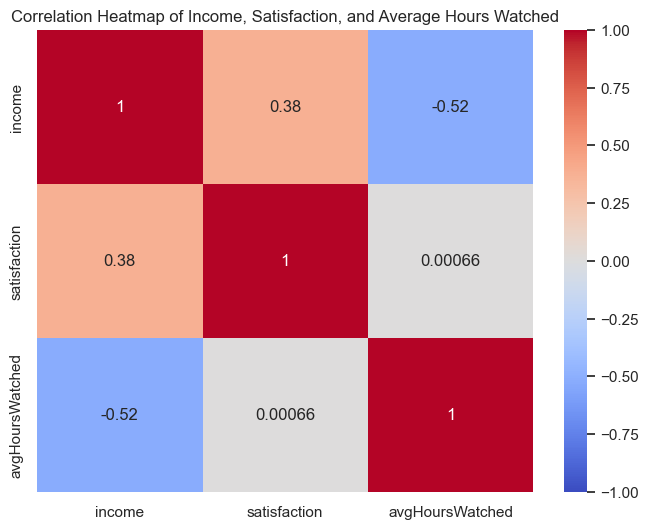

In [27]:
#INSTRUCTION: create a correlation plot that shows the correlation matrix you chose. 

import seaborn as sns
import matplotlib.pyplot as plt

# Compute the Spearman correlation matrix
correlation_matrix = netflix_users[['income', 'satisfaction', 'avgHoursWatched']].corr(method='spearman') # use pearson for Pearson correlation

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)

# Set the title and labels
plt.title('Correlation Heatmap of Income, Satisfaction, and Average Hours Watched')
plt.show()

#### Stratified box plots

But what if we want to see if a categorical variable, such as gender or country, has a relationship with a metric or ordinal variable, such as income or satisfaction?

In this case, we can create stratified box plots and compare their distribution.

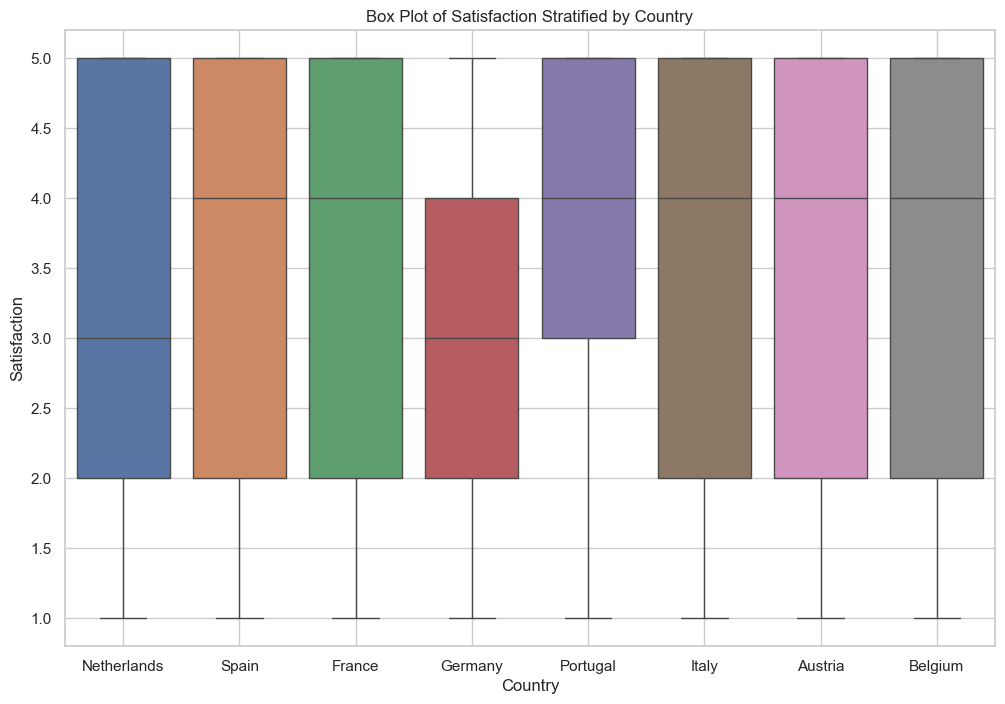

In [28]:
#INSTRUCTION: create a stratified box plot that shows users satisfaction by country. (Hint: use country as the 'hue' attribute in sns.boxplot)

import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for the box plot
plt.figure(figsize=(12, 8))

# Box plot for Satisfaction stratified by Country
sns.boxplot(x='country', y='satisfaction', data=netflix_users, hue='country')
plt.title('Box Plot of Satisfaction Stratified by Country')
plt.xlabel('Country')
plt.ylabel('Satisfaction')
plt.grid(True)

plt.show()


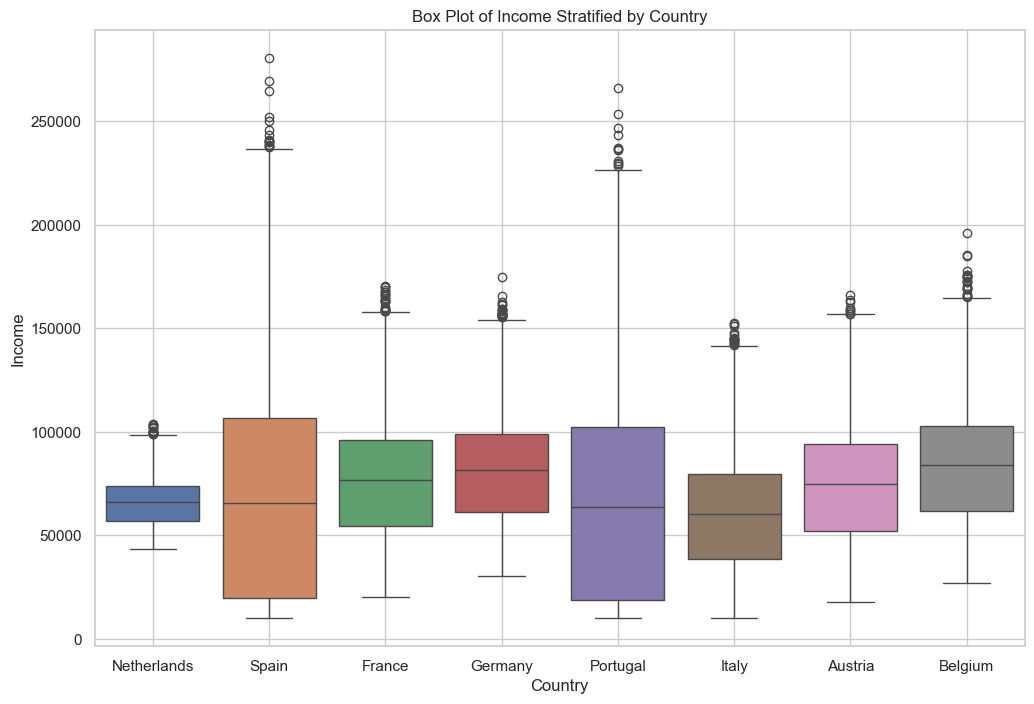

In [27]:
#INSTRUCTION: create a stratified box plot that shows users income by country. (Hint: use country as the 'hue' attribute in sns.boxplot)

import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for the box plot
plt.figure(figsize=(12, 8))

# Box plot for Satisfaction stratified by Country
sns.boxplot(x='country', y='income', data=netflix_users, hue='country')
plt.title('Box Plot of Income Stratified by Country')
plt.xlabel('Country')
plt.ylabel('Income')
plt.grid(True)

plt.show()


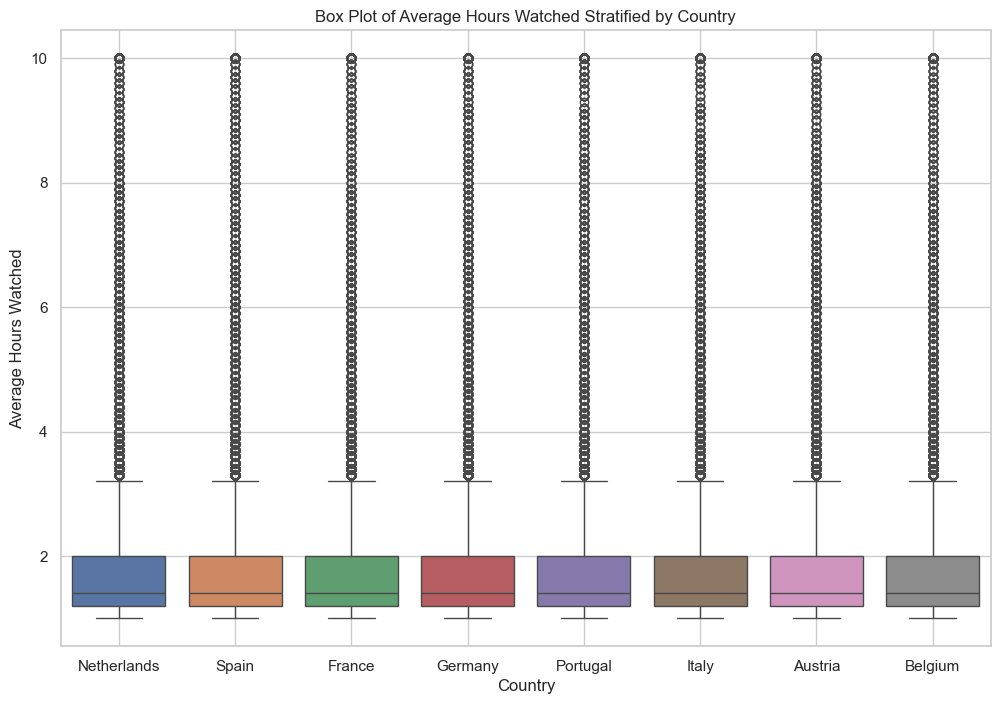

In [29]:
#INSTRUCTION: create a stratified box plot that shows users average hours watched by country. (Hint: use country as the 'hue' attribute in sns.boxplot)

import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for the box plot
plt.figure(figsize=(12, 8))

# Box plot for Satisfaction stratified by Country
sns.boxplot(x='country', y='avgHoursWatched', data=netflix_users, hue='country')
plt.title('Box Plot of Average Hours Watched Stratified by Country')
plt.xlabel('Country')
plt.ylabel('Average Hours Watched')
plt.grid(True)

plt.show()


### 1.2.4 Summary statistics table

In [30]:
#INSTRUCTIONS: create a summary statistics table that shows the number of observations, the mean, the standard deviation, the min, the max, and the correlation for the variables
#satisfaction', 'income', 'avgHoursWatched', 'premSub'.

import pandas as pd

# Select relevant columns
data = netflix_users[['satisfaction', 'income', 'avgHoursWatched', 'premSub']]

# Calculate summary statistics
summary_stats = data.describe().T[['count', 'mean', 'std', 'min', 'max']]

# Calculate correlations with other variables
correlations = data.corr()

# Merge summary statistics and correlation information
summary_table = summary_stats.join(correlations, lsuffix='_stat')

# Rename the columns for clarity
summary_table.columns = [
    'N', 
    'Mean', 
    'S.D.', 
    'Min', 
    'Max', 
    '(1)', 
    '(2)', 
    '(3)', 
    '(4)'
]

# rename row index
summary_table = summary_table.rename(index={'satisfaction' : "(1) Satisfaction", 'income' : "(2) Income", 'avgHoursWatched': "(3) Hours Watched", 'premSub': "(4) Premium Sub"})

# Print the summary table
summary_table = np.round(summary_table,2)
summary_table


,N,Mean,S.D.,Min,Max,(1),(2),(3),(4)
(1) Satisfaction,200000.0,3.41,1.27,1.0,5.00,1.00,0.37,0.00,-0.0
(2) Income,200000.0,71218.28,34692.61,10000.0,280480.48,0.37,1.00,-0.49,-0.0
(3) Hours Watched,200000.0,1.90,1.42,1.0,10.00,0.00,-0.49,1.00,0.0
(4) Premium Sub,200000.0,0.54,0.50,0.0,1.00,-0.00,-0.00,0.00,1.0


## 2. Elements of Probability Theory

## 2.1 Sample and population

Usually, we use statistical methods to make statments about a population. However, typically we do not have data on the whole population.

Lets assume that the data we simulated covers the whole population of our streaming platform. If this is true then in reality we often only 
work with a sample of this population. 

#### Drawing samples

To simulate this situation, we can draw a random sample from our population of 200,000 streaming users.

In [31]:
# INSTRUCTIONS: draw a random sample of 20,000 users from the overall data set. (use 42 as random state)

# Draw a random sample of 20,000 users
sampled_users = netflix_users.sample(n=20000, random_state=42)#random_state to get always the same random sample

# Reset the index for the sampled data
sampled_users.reset_index(drop=True, inplace=True)

# Display the first few rows of the sampled data
print(sampled_users.head())

       ID  age  gender      country     favGenre  premSub  satisfaction  \
0  119738   42  Female  Netherlands       Horror        1           5.0   
1   72273   57    Male  Netherlands  Documentary        0           5.0   
2  158155   39  Female       France  Documentary        1           3.0   
3   65427   43  Female      Belgium       Action        1           2.0   
4   30075   43  Female      Germany       Action        1           4.0   

   avgHoursWatched         income  avgHoursWatched_log2  avgHoursWatched_log10  
0              1.2   74289.640229              0.263034               0.079181  
1              1.1   69496.229714              0.137504               0.041393  
2              2.6   30445.285555              1.378512               0.414973  
3              1.4   61018.146276              0.485427               0.146128  
4              1.0  102895.939084              0.000000               0.000000  


## 2.2 Comparing sample and population (mean, standard deviation)

In [32]:
# INSTRUCTION: compare the sample mean, median, and other quantiles with the population values.# expected to be coded!!!

# Compute population metric
population_mean_income = netflix_users['income'].mean()
population_median_income = netflix_users['income'].median()
population_q25_income = netflix_users['income'].quantile(0.25)
population_q75_income = netflix_users['income'].quantile(0.75)

# Compute sample metrics
sample_mean_income = sampled_users['income'].mean()
sample_median_income = sampled_users['income'].median()
sample_q25_income = sampled_users['income'].quantile(0.25)
sample_q75_income = sampled_users['income'].quantile(0.75)

# create a data frame to compare metrics# not expected to be coded
comparison_table =pd.DataFrame({
    'population': [population_mean_income, population_median_income, population_q25_income, population_q75_income],
    'sample': [sample_mean_income, sample_median_income, sample_q25_income, sample_q75_income]
}, index=['mean', 'median', 'q25', 'q75'])

comparison_table

,population,sample
mean,71218.282676,71150.794351
median,71430.566718,71115.717200
q25,48468.355417,48477.247054
q75,93321.478195,93412.680526


## 2.3 Conditional probability

#### Question to you
What is the probability that an individual has a premium subscription, given that they prefer 'action' movies as their favorite genre?

We can use the following formula to compute the conditional probability<br>

**P(P|A) = P(P∩A) / P(A)**

P(P|A) = conditional probability of having a premium subscription given that one prefers action movies <br>
P(P∩A) = the probability of having a premium subscription and prefering action movies <br>
P(A) = the probability of having a premium subscription

We can use the crosstab function to compute frequencies for all groups

In [33]:
crosstab_sampled_users = pd.crosstab(index=sampled_users['premSub'], columns=sampled_users['favGenre'], margins=True)
crosstab_sampled_users

favGenre,Action,Comedy,Documentary,Horror,Romance,All
premSub,,,,,,
0,577,1635,3501,1545,2007,9265
1,3421,2494,487,2347,1986,10735
All,3998,4129,3988,3892,3993,20000


We can use the .iloc[row, column] to acces the respective rows and columns

In [34]:
print(np.round(crosstab_sampled_users.iloc[1,0]/crosstab_sampled_users.iloc[2,0],2))

0.86


## 3. Distributions

## 3.1 Sampling from different distributions

### 3.1.1 The normal distribution

$\mu$ is the loc parameter <br>
$\sigma^2$ is the scale parameter

In [35]:
#INSTRUCTION take a random sample with 10 observations(size) from a normal distribution with mean=35(loc) and sigma^2=12(scale)
np.random.normal(loc=35, scale=12, size=10)

array([40.92585823, 38.0104345 ,  7.24365591, 31.88040923, 26.97851549,
       33.98732552, 25.36475929, 51.01855562, 30.18276581, 30.96465399])

### 3.1.2 The exponential distribution <br>

The scale parameter $\beta$ = 1/$\lambda$ must be non-negative

In [36]:
#INSTRUCTION take a random sample with 10 observations from an exponential distribution with lambda = 12
np.random.exponential(scale=12, size=10)

array([26.01226904,  6.66166915,  5.79844888,  5.36152093,  6.39228414,
        4.10576403,  1.47905972,  0.8009976 ,  3.059184  ,  4.46604329])

See: https://numpy.org/doc/stable/reference/random/legacy.html for more distributions.

### 3.1.3 Computing probabilities based on distributions 

You are working for a startup that sells food supplements. <br>
Due to a faulty machines, the boxes you are selling vary in weight. <br>
You assume the weight to be normally distributed with mu = 500g and sigma^2 = 10g2.<br>
You want to avoid customers being unsatisfied because their boxes are too low in weight.<br>
Therefore, you want to know what is the probability that a box with a weight of less than 495g is sold. <br>

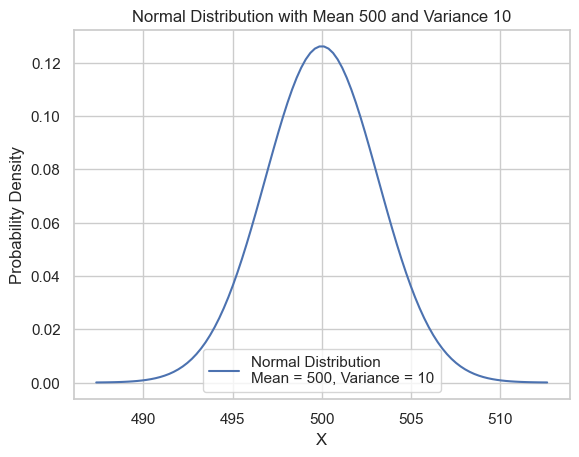

  The probability that a box weighs less than 495 is: 0.057


In [43]:
#INSTRUCTION: compute the probability that a box has a weight of less than 495g. 

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 500
variance = 10
sigma = math.sqrt(variance) # standard deviation
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)

# Plot the normal distribution
plt.plot(x, stats.norm.pdf(x, mu, sigma), label=f'Normal Distribution\nMean = {mu}, Variance = {variance}')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.title('Normal Distribution with Mean 500 and Variance 10')
plt.legend()
plt.grid(True)
plt.show()

print(f"  The probability that a box weighs less than 495 is: {stats.norm.cdf(495, 500, math.sqrt(10)):.3f}")

Be aware of the difference between cdf and pdf! 

**cdf** stands for cumulative distribution function. It returns the area under the curve to the left of x. We use it to compute probabilities. <br>
**pdf** stands for probability density function. It returns the hight of the curve at x. We use it to plot the normal distribution. It reprersents the density (not a probability!).

## 3.2 Central limit theorem

The Central Limit Theorem (CTL) tells us that when we take a sufficiently large sample size n from a population with any shape of distribution (with a finite mean and variance), the distribution of the sample mean will approximate a normal distribution. This approximation improves as the sample size increases, regardless of the original distribution's shape.

Sampling from a uniform distribution

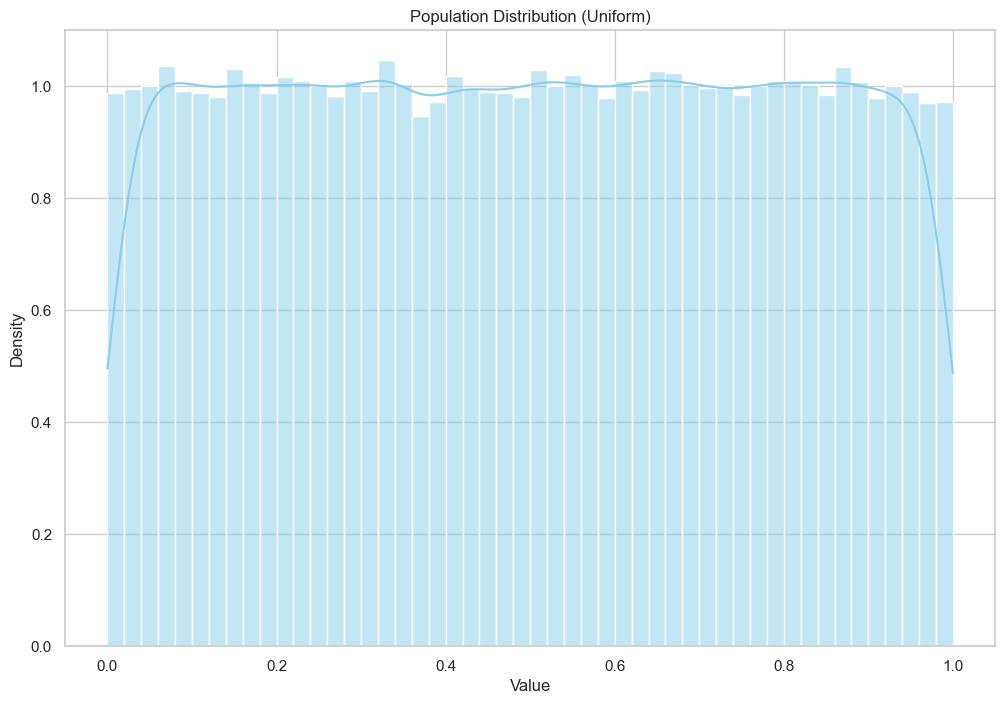

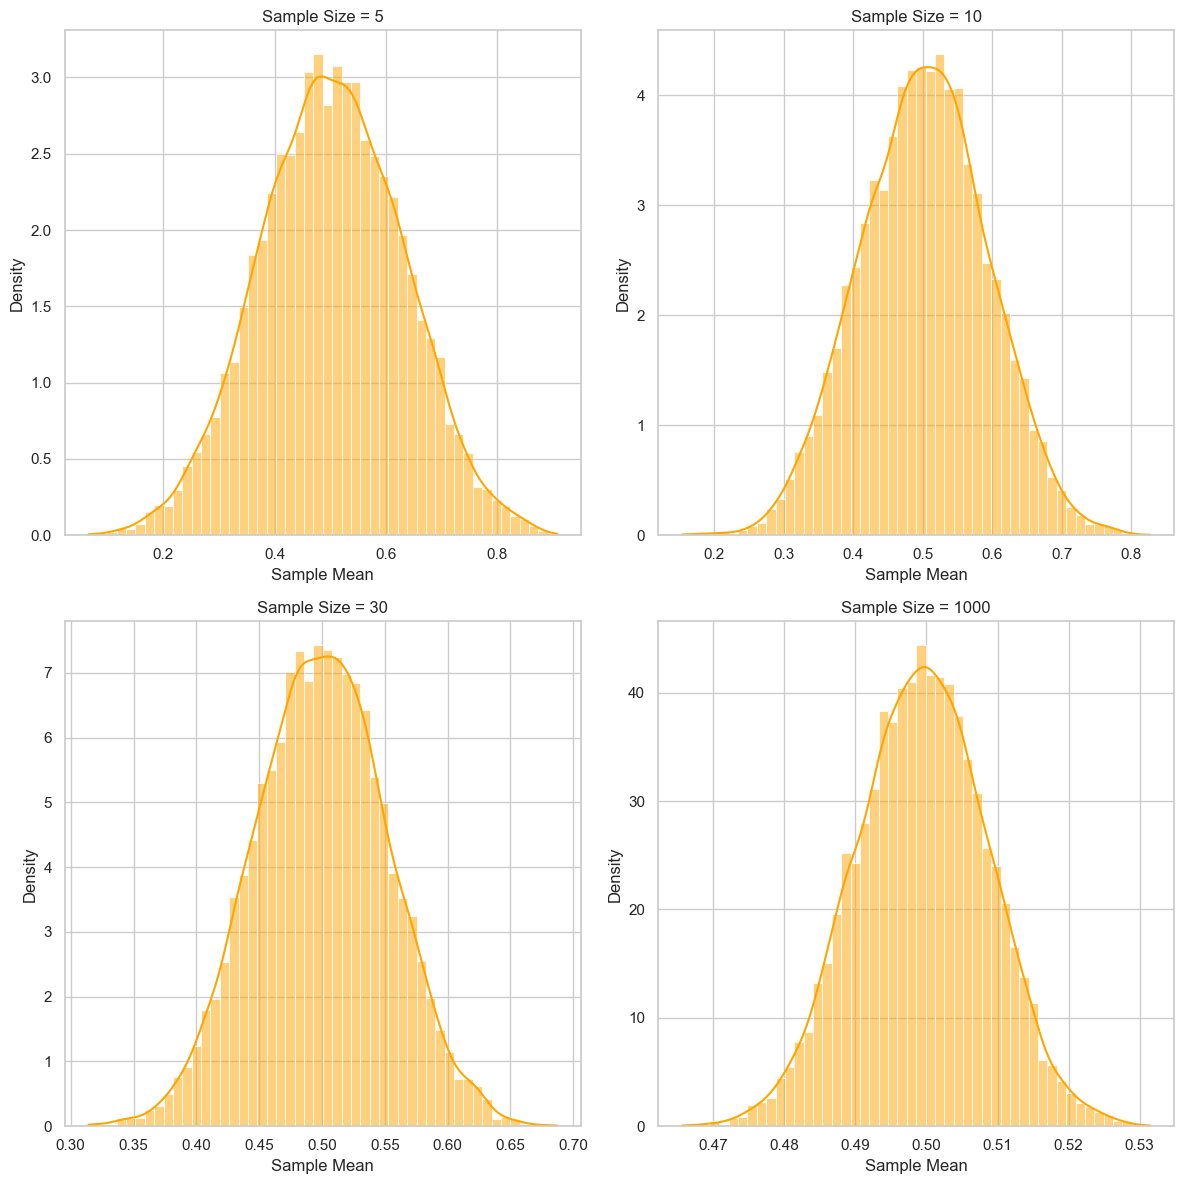

In [33]:
#INSTRUCTION: prove the CLT visually by sampling from a uniform distribution.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the parameters
np.random.seed(42)  # For reproducibility
population_size = 100000
sample_sizes = [5, 10, 30, 1000]
num_samples = 10000

# Generate a population from a uniform distribution
population = np.random.uniform(low=0.0, high=1.0, size=population_size)

# Plot the population distribution
plt.figure(figsize=(12, 8))
sns.histplot(population, bins=50, kde=True, color='skyblue', stat="density")
plt.title('Population Distribution (Uniform)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Function to draw sample means
def sample_means(sample_size, num_samples):
    means = []
    for _ in range(num_samples):
        sample = np.random.choice(population, size=sample_size)
        means.append(np.mean(sample))
    return means

# Plot sample means for different sample sizes
plt.figure(figsize=(12, 12))

for i, sample_size in enumerate(sample_sizes):
    means = sample_means(sample_size, num_samples)
    plt.subplot(2, 2, i+1)
    sns.histplot(means, bins=50, kde=True, color='orange', stat="density")
    plt.title(f'Sample Size = {sample_size}')
    plt.xlabel('Sample Mean')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


Sampling from an exponential distribution

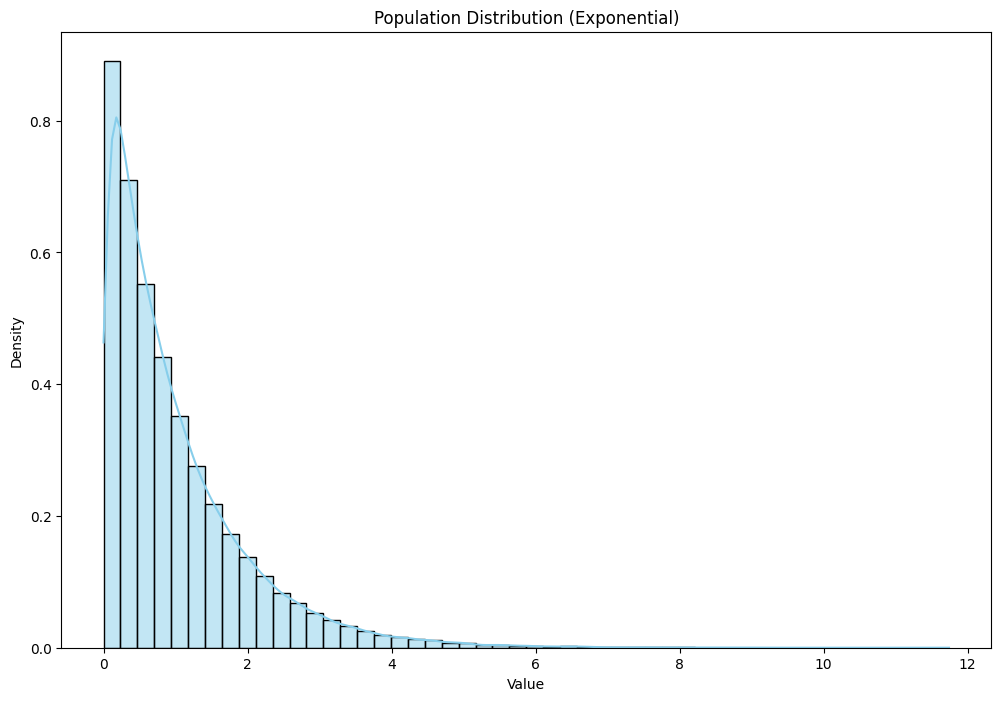

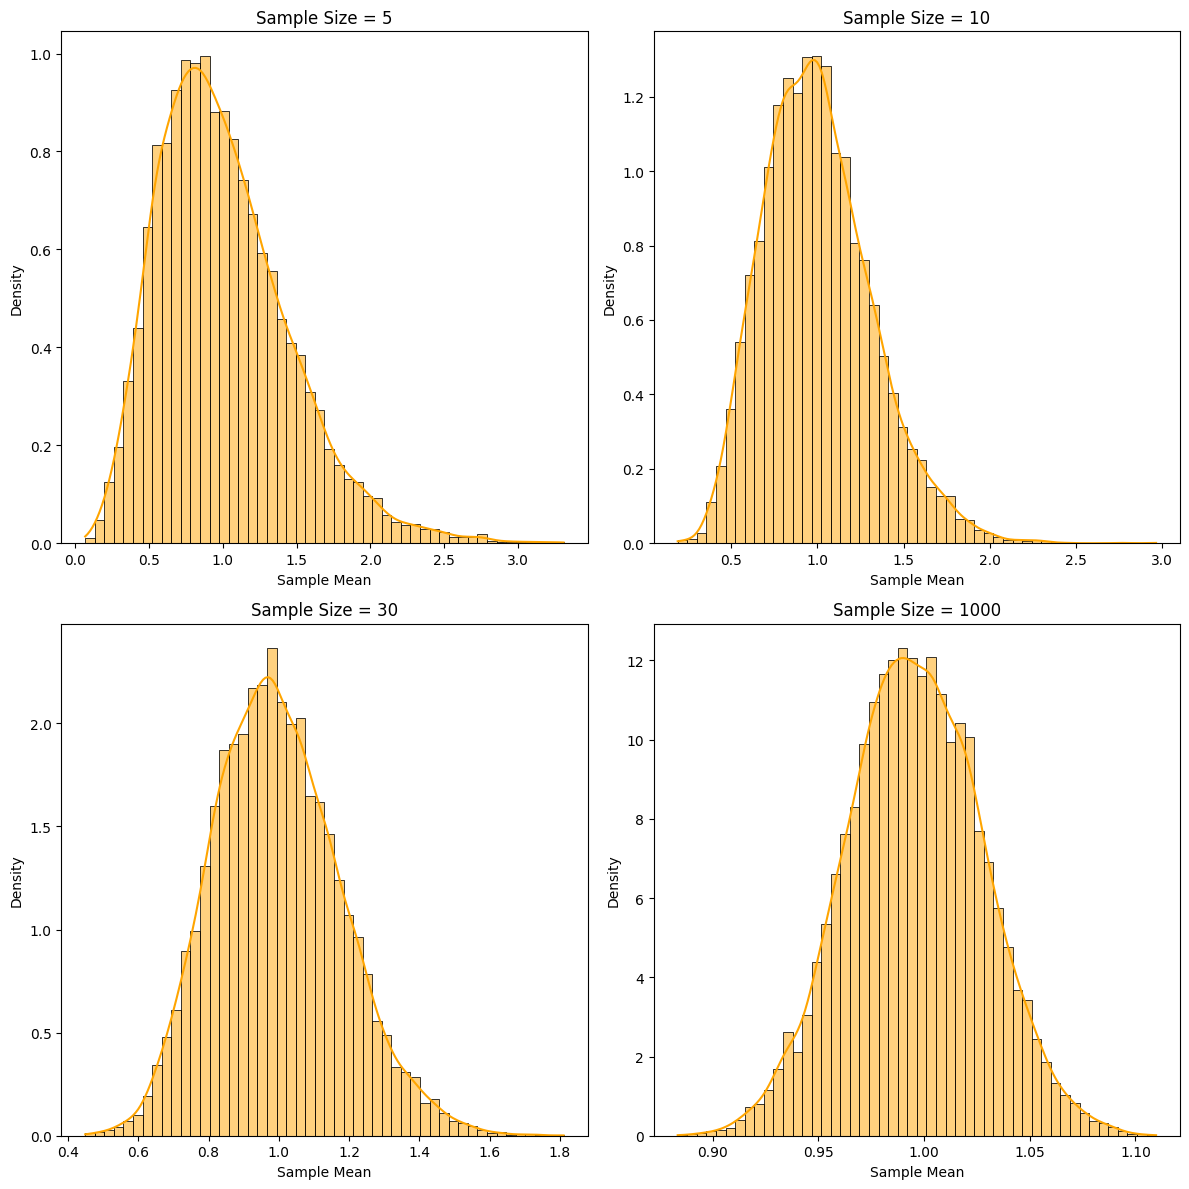

In [32]:
#INSTRUCTION: prove the CLT visually by sampling from a exponential distribution.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the parameters
np.random.seed(42)  # For reproducibility
population_size = 100000
sample_sizes = [5, 10, 30, 1000]
num_samples = 10000

# Generate a population from an exponential distribution
population = np.random.exponential(scale=1.0, size=population_size)

# Plot the population distribution
plt.figure(figsize=(12, 8))
sns.histplot(population, bins=50, kde=True, color='skyblue', stat="density")
plt.title('Population Distribution (Exponential)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Function to draw sample means
def sample_means(sample_size, num_samples):
    means = []
    for _ in range(num_samples):
        sample = np.random.choice(population, size=sample_size)
        means.append(np.mean(sample))
    return means

# Plot sample means for different sample sizes
plt.figure(figsize=(12, 12))

for i, sample_size in enumerate(sample_sizes):
    means = sample_means(sample_size, num_samples)
    plt.subplot(2, 2, i+1)
    sns.histplot(means, bins=50, kde=True, color='orange', stat="density")
    plt.title(f'Sample Size = {sample_size}')
    plt.xlabel('Sample Mean')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


# Summary and Key Takeaways

1. **Data Generation**: We created a synthetic dataset of streaming platform users with realistic distributions and relationships between variables.

2. **Exploratory Data Analysis**:
   - Examined variable types and their distributions
   - Calculated descriptive statistics
   - Visualized relationships between variables
   - Identified patterns and correlations

3. **Probability Theory**:
   - Distinguished between population and sample statistics
   - Explored conditional probabilities
   - Demonstrated the Central Limit Theorem in action
